<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200"> 

# Домашка №5: регрессия

Давайте выясним, как профиль вк помогает нам предугадывать число лайков студента первого курса в вышкинском паблике с мемасами.

По ходу кода ниже будет довольно много пустых строк. Нужно заполнить их своим кодом.

In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

Полезная функция для визуализации результатов модели.

In [2]:
# Функция для визуализации прогнозов 

def plot_yreal_ypred(y_test, y_train, X_test, X_train, model, margin=0.3):
    """
        Рисует картинку для прогнозов
            modelt - модель 
            y_train, X_train - обучающая выборка
            y_test, X_test - тестовая выборка
            margin - граница рисунка 
    """
    
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    plt.scatter(y_train, model.predict(X_train), color="red", alpha=1)
    plt.xlim(min(y_train) - margin, max(y_train) + margin)
    plt.ylim(min(y_train) - margin, max(y_train) + margin)
    plt.title('Train set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)

    plt.subplot(122)
    plt.scatter(y_test, model.predict(X_test), color="red", alpha=1)
    plt.xlim(min(y_test) - margin, max(y_test) + margin)
    plt.ylim(min(y_test) - margin, max(y_test) + margin)
    plt.title('Test set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)
    pass

На семинаре мы разобрали пример с рейтингами видеоконтента. Давайте вспомним, какие шаги мы проходили:

1. Обрабатываем данные
2. Строим константный прогноз
3. Строим линейную регрессию c MSE в качестве функции ошибки
4. Находим лучшие гиперпараметры по сетке и строим случайный лес
5. Сравниваем качество прогнозов и делаем выводы


Подгружаем данные.

In [3]:
df = pd.read_csv('vk_main.csv', sep='\t')   # подгружаем датасет
print('Размерность таблицы:', df.shape)   
df.head()

Размерность таблицы: (425, 98)


,city,country,first_name,home_town,in_hse_memes_group,is_bmm,is_closed,last_name,likes_memes,uid,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Александра,Москва,True,True,False,Абашкова,60.0,182152789,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,42.0,0.428571
1,Рязань,Россия,Анастасия,Рязань,True,True,False,Чуфистова,0.0,148020433,...,2.375000,2.0,1.0,0.105263,0.0,0.0,0.0,0.0,32.0,0.281250
2,Москва,Россия,Александр,Омск,False,True,False,Головачев,0.0,138413935,...,1.400000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,32.0,0.406250
3,NaN,NaN,Анна,NaN,False,True,False,Лобанова,0.0,366261055,...,4.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,45.0,0.333333
4,NaN,Россия,Алексей,NaN,True,True,False,Пузырный,21.0,111252392,...,3.181818,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,41.0,0.341463


# 1. Смотрим на данные

Давайте посмотрим на наши переменные. Начнем с нашей предсказываемой переменной, числа лайков.

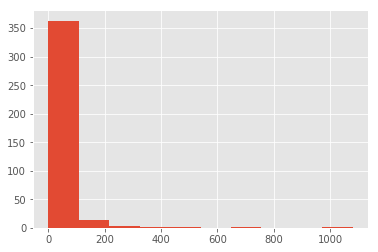

In [4]:
df.likes_memes.hist();

Мы видим тяжелый хвост. В данных куча выбросов. Мы уже умеем с этим бороться. 

__[0.5] Прологарифмируйте переменную и постройте для её логарифма гистограмму.__

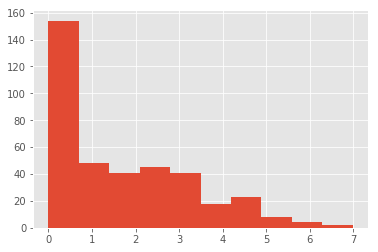

In [5]:
df['ln_likes_memes'] = df['likes_memes'].apply(lambda w: np.log(w + 1))
df.ln_likes_memes.hist()

Помните, в прошлый раз мы сталкивались с пропусками в данных? Давайте посмотрим, что насколько полные в этом плане у нас данные. 
Визуализируем табличку данных, раскрасим желтым цветом пропуски, фиолетовым - наблюдения. 

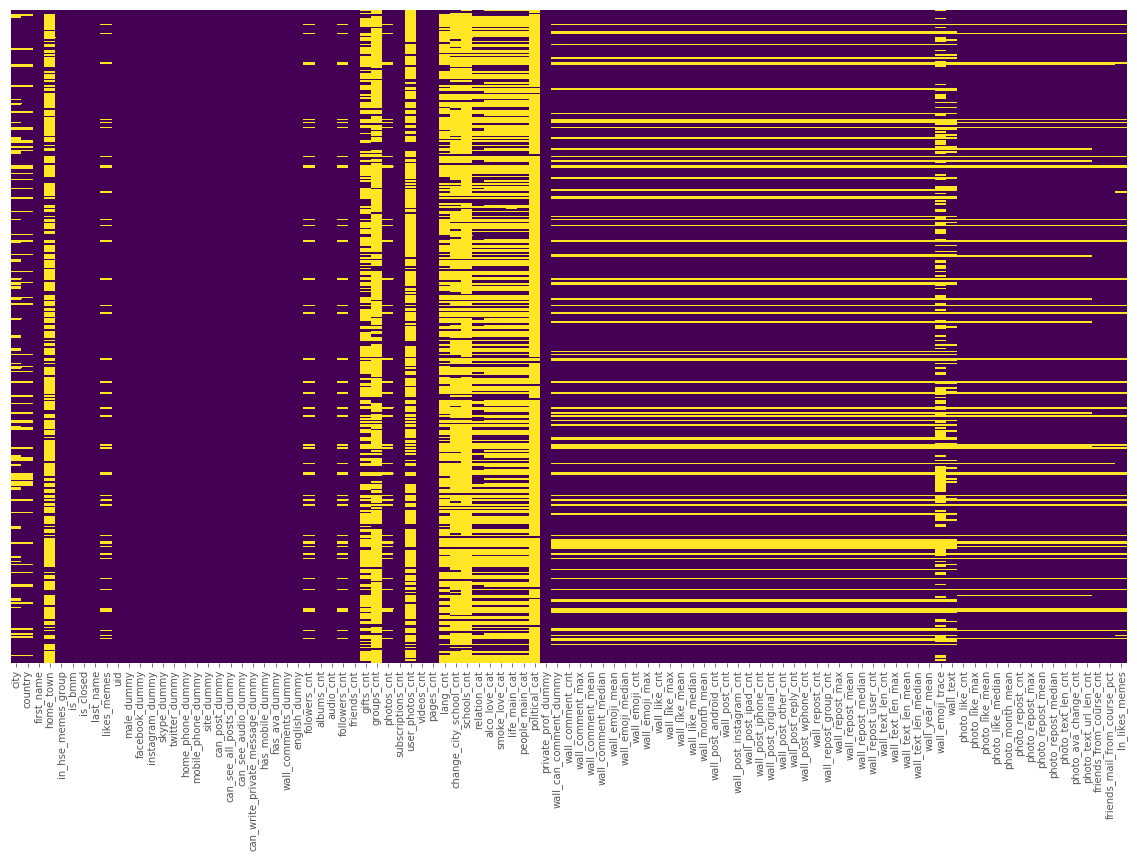

In [6]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

У нас есть целые столбцы желтого цвета, т.е. они не несут для нас информации (они же пустые). Очень большое число пропусков связано с приватностью странички (таких $82$). Давайте выкинем из рассмотрения все данные, где пропусков больше $82$ и все наблюдения, где предсказываемая переменная пустая. 

__[1] Сделайте это :)__

In [7]:
print('Переменных до выбрасывания:', df.shape)

isnull = df.isnull().sum()
df = df[isnull[isnull < 82].index]
df = df[(df.ln_likes_memes.isnull() == False)]

print('Переменных после выбрасывания:', df.shape)

Переменных до выбрасывания: (425, 99)
Переменных после выбрасывания: (384, 49)


Все переменные, которые есть в выборке делятся на несколько типов. Я специально постарался отразить их типы в названиях. Давайте посмотрим на то, какие это типы.

## 1.1 Переменные счётчики
Количество друзей, количество подписчиков, число фоток - всё это счётчики!

In [8]:
variables_cnt = [item for item in df.columns if item[-3:] == 'cnt']
variables_cnt[:5]

['folowers_cnt', 'albums_cnt', 'audio_cnt', 'followers_cnt', 'friends_cnt']

Давайте их визуализируем.

__[1] Постройте гистограммы для всех счётчиков__

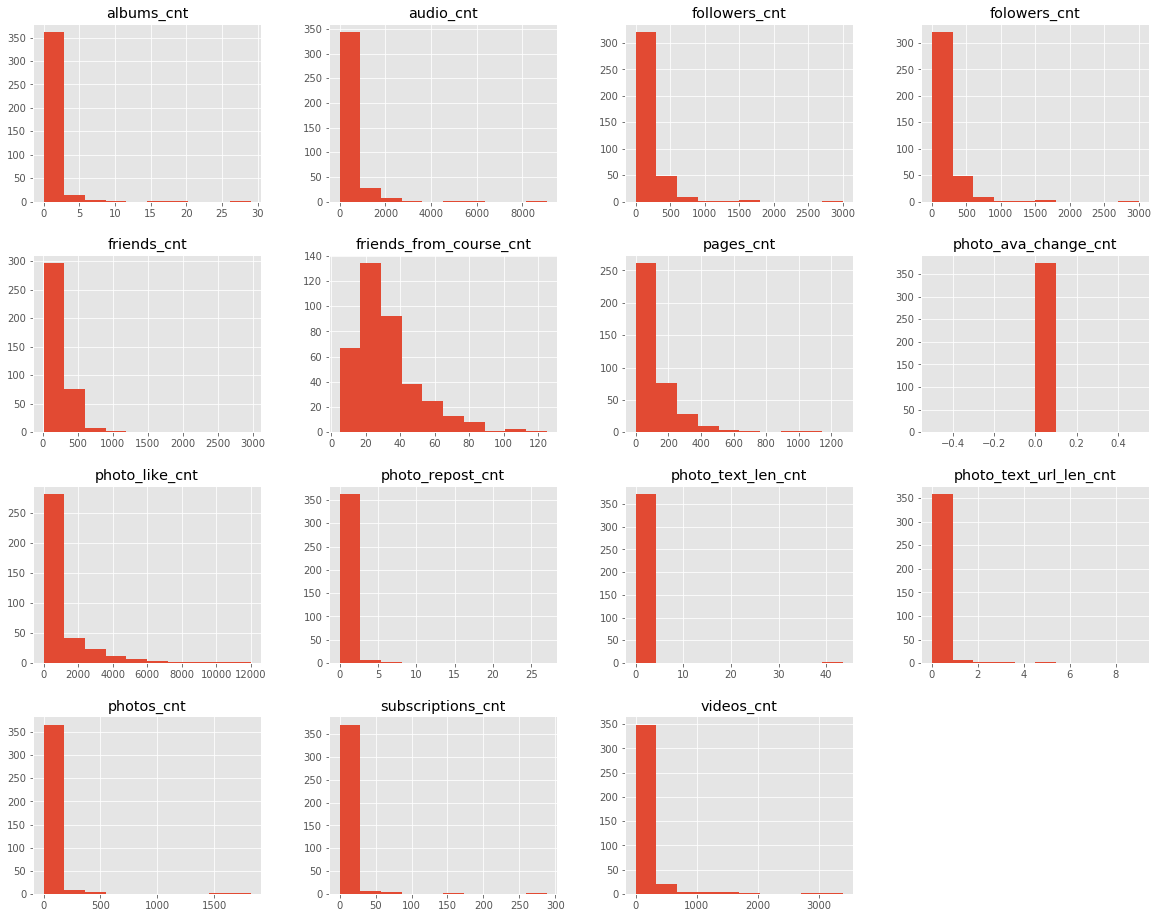

In [9]:
# Ваша одна строчка кода 
df[variables_cnt].hist(figsize=(20,16));

Видим две вещи: 

* У многих счётчиков длинные хвосты => выбросы => придется их сглаживать.
* Многие счётчики не очень информативны: принимают одно или два значения => придется такие счётчики выбросить. 

In [10]:
print('Переменных-счётчиков до отбрасывания:', len(variables_cnt))

# Оставим только те счётчики, которые принимают больше 10 значений 
variables_cnt = [item for item in variables_cnt if len(df[item].unique()) > 10]

print('Переменных-счётчиков после отбрасывания:', len(variables_cnt))

Переменных-счётчиков до отбрасывания: 15
Переменных-счётчиков после отбрасывания: 11


Многие оставшиеся перемннные имеют тяжелые хвосты. Что мы с ними делаем?

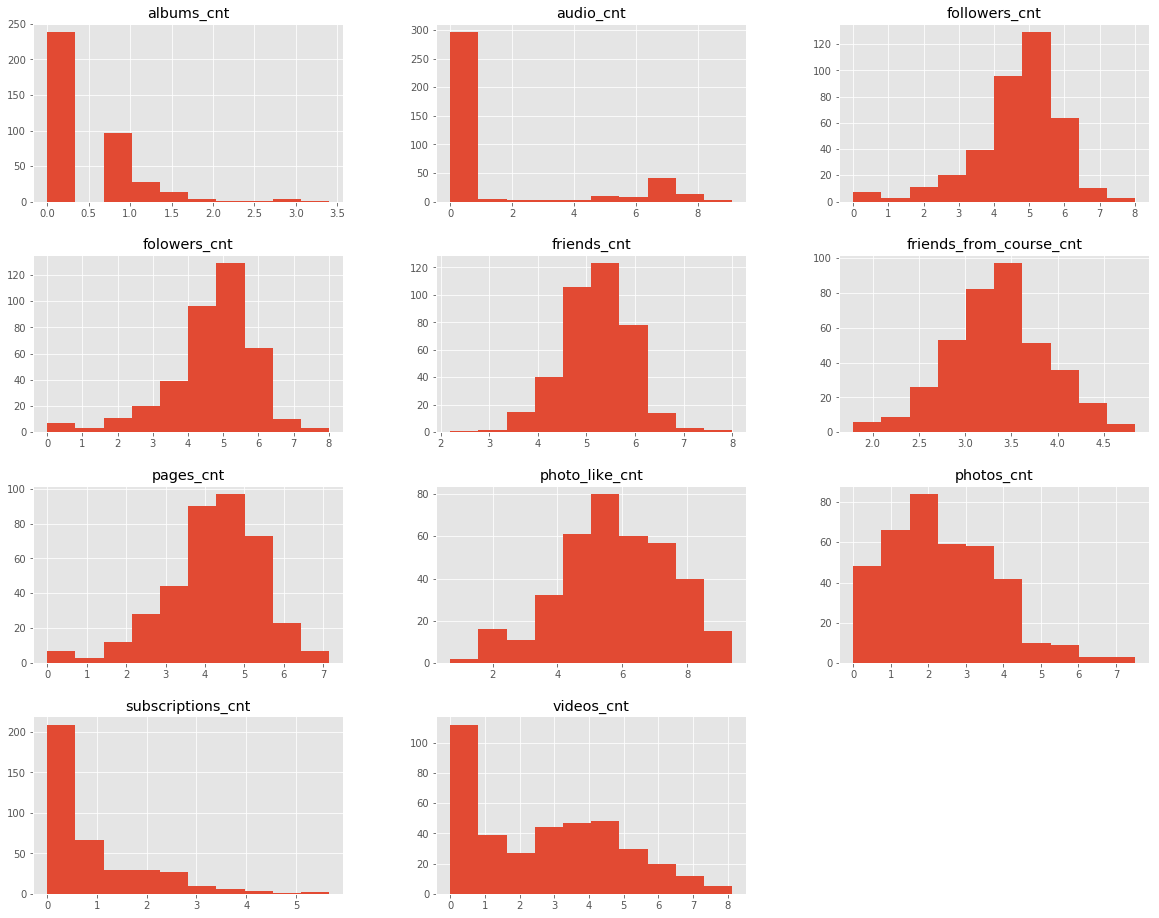

In [11]:
df[variables_cnt] = df[variables_cnt].apply(lambda w: np.log(w + 1))
df[variables_cnt].hist(figsize=(20,16));

## 1.2 Dummy - переменные
 
У нас также есть переменные, принимающие значения 0 или 1, давайте на них посмотрим.

In [12]:
variables_dummy = [item for item in df.columns if item[-5:] == 'dummy']
variables_dummy[:5]

['male_dummy',
 'facebook_dummy',
 'instagram_dummy',
 'skype_dummy',
 'twitter_dummy']

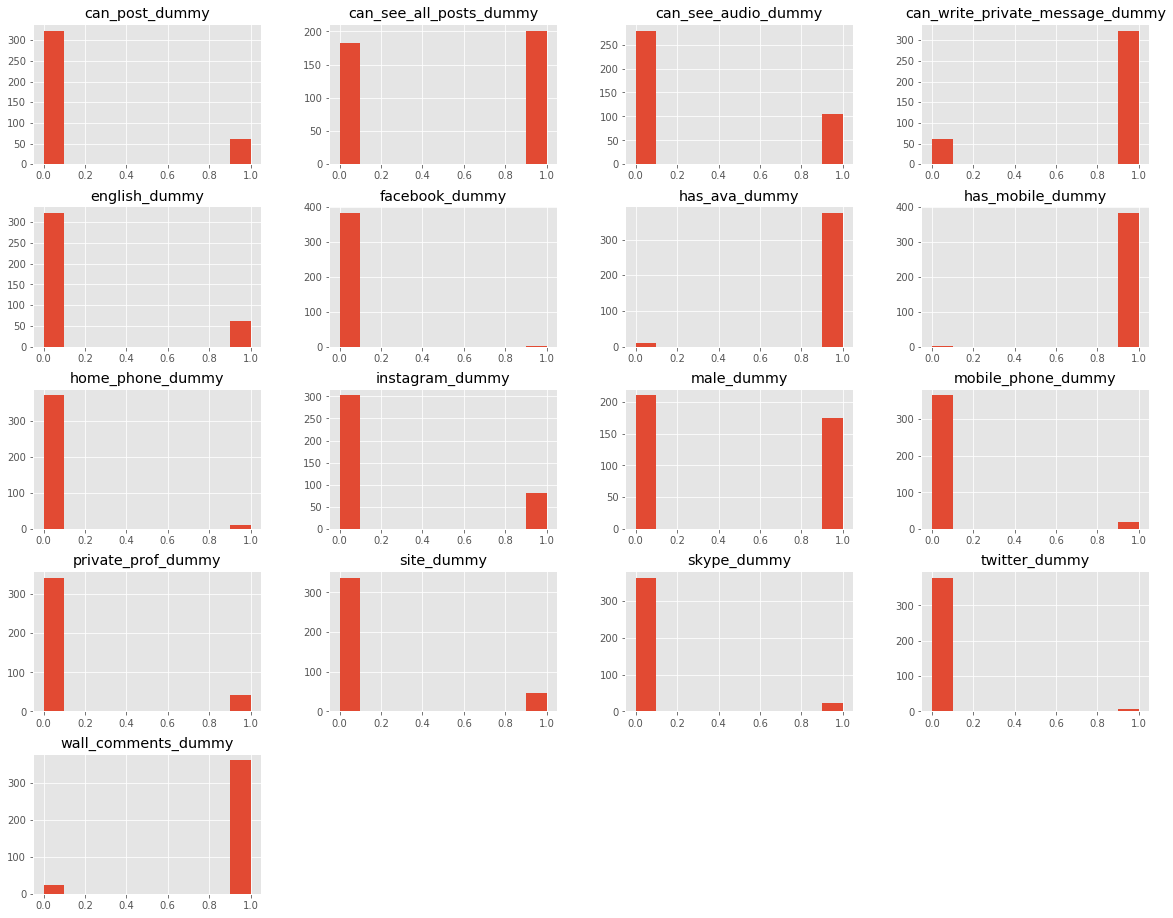

In [13]:
df[variables_dummy].hist(figsize=(20,16));

Есть несколько не очень информативных переменных. Например, наличие твиттера или указан ли телефон. Почти у всех там стоят нули. То есть твиттер и телефон не указаны. Можно было бы выкинуть эти переменные, но мы пожалуй не будем. 

## 1.3 Средние и медианы

Мы посчитали по каждому пользователю среднее число комментов на стене, среднее количество репостов, эмодзи и другие подобные характеристики. Давайте на них взглянем.

In [16]:
df.columns

Index(['country', 'first_name', 'in_hse_memes_group', 'is_bmm', 'is_closed',
       'last_name', 'likes_memes', 'uid', 'male_dummy', 'facebook_dummy',
       'instagram_dummy', 'skype_dummy', 'twitter_dummy', 'home_phone_dummy',
       'mobile_phone_dummy', 'site_dummy', 'can_post_dummy',
       'can_see_all_posts_dummy', 'can_see_audio_dummy',
       'can_write_private_message_dummy', 'has_mobile_dummy', 'has_ava_dummy',
       'wall_comments_dummy', 'english_dummy', 'folowers_cnt', 'albums_cnt',
       'audio_cnt', 'followers_cnt', 'friends_cnt', 'photos_cnt',
       'subscriptions_cnt', 'videos_cnt', 'pages_cnt', 'private_prof_dummy',
       'photo_like_cnt', 'photo_like_max', 'photo_like_mean',
       'photo_like_median', 'photo_month_mean', 'photo_repost_cnt',
       'photo_repost_max', 'photo_repost_mean', 'photo_repost_median',
       'photo_text_len_cnt', 'photo_ava_change_cnt', 'photo_text_url_len_cnt',
       'friends_from_course_cnt', 'friends_mail_from_course_pct',
       '

In [14]:
variables_mean = [item for item in df.columns if item[-4:] == 'mean']
variables_mean[:5]

['photo_like_mean', 'photo_month_mean', 'photo_repost_mean']

In [15]:
variables_median = [item for item in df.columns if item[-6:] == 'median']
variables_median[:5]

['photo_like_median', 'photo_repost_median']

In [ ]:
df[variables_median].hist(figsize=(10,8));

Как мы знаем, медиана и среднее могут быть сильно коррелированы, что плохо отражается на линейных моделях регрессии. Давайте посмотрим на матрицу корреляции и выберем один из способов агрегации.

In [ ]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df[variables_median + variables_mean].corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Давайте оставим медианы. Опять тяжелые хвосты, видно на картинке выше - да, опять.

In [ ]:
variables_descriptive = variables_median 
df[variables_descriptive] =  df[variables_descriptive].apply(lambda w: np.log(w + 1))

Соберем все оставшиеся переменные и заполним пропуски нулями.

In [ ]:
useful_variables = variables_cnt + variables_dummy + variables_descriptive + ['friends_mail_from_course_pct']
df[useful_variables] = df[useful_variables].fillna(0)
df.head()

## 1.4 Категориальные переменные 

Название говорит само за себя. 

In [ ]:
variables_cat = [item for item in df.columns if item[-3:] == 'cat']
variables_cat[:5]

В данных их нет. Но на семинаре были. __И на котнтрольной обязательно будут.__ Посмотрите ещё раз в семинаре как с ними необходимо работать. 

Данные подготовили, пора в бой.

#### [2] Давайте делить выборку.


In [ ]:
#кодить тут

In [ ]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 80 к 20
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42)


Запишем в отдельные переменные наши обучающие и тестовые выборки. Так буде удобнее.

In [ ]:
y_train = df_train['ln_likes_memes'].get_values()
y_test = df_test['ln_likes_memes'].get_values()

X_train = df_train[useful_variables].get_values()
X_test = df_test[useful_variables].get_values()

#### [3] Объясните зачем выборку разбивают на тренировочную и тестовую

Ответ:

# Наивный константный прогноз


#### [4] Постройте константный прогноз ровно также, как мы делали это на семинаре.

In [ ]:
#кодить тут

In [ ]:
y_mean = np.mean(y_train)
y_pred_naive = np.ones(len(y_test)) * y_mean

Теперь давайте посмотрим на тестовой выборке насколько константный прогноз получился хорошим. Будем использовать в качестве метрики качества $MAE$. Подгрузите метрику из sklearn и выясните качество работы константного прогноза на тестовой выборке. За вдохновением можно снова обратиться к семинару, но не вздумайте переписывать один в один функцию print_metrics. За это буду отнимать баллы.

#### [5] Найдите MAE константного прогноза.

In [ ]:
#кодить тут

In [ ]:
from sklearn import metrics
metrics.mean_absolute_error(y_test, y_pred_naive)

Отлично! Теперь у нас есть с чем сравнить более сложные модели. Давайте займёмся их строительством.

# Линейная регрессия

Давайте оставим для работы только те переменные, которые сильнее всего коррелируют с таргетомю. Вот так это можно сделать для топ-10 положительных переменных:

In [ ]:
corr_pos =  df_train[useful_variables].corrwith(df_train['ln_likes_memes']).sort_values(ascending=False)
corr_pos[:10]

#### [6] Запишите в переменную corr_neg топ-10 переменных с негативной корреляцией

In [ ]:
#кодить тут

In [ ]:
corr_neg = df_train[useful_variables].corrwith(df_train['ln_likes_memes']).sort_values(ascending=True)
corr_neg[:10]

Оставляем только коррелируемые переменные.

In [ ]:
# оставляем в выборке только самые важные переменные 
best_variables = list(corr_pos[:10].index) + list(corr_neg[:10].index)

# Забираем в выборку лучших из лучших 
X_train = df_train[best_variables].get_values()
X_test = df_test[best_variables].get_values()


Теперь давайте наконец обучим на отобранных признаках линейную регрессию.

#### [7] Оцените линейную регрессию. Посмотрите на её MAE. 

Постройте для неё с помощью функции plot_yreal_ypred, которую мы объявили в начале тетрадки, визуализацию её прогнозов. Сравните качество модели с константным прогнозом. Сделайте выводы о работоспособности модели.

In [ ]:
#кодить тут

In [ ]:
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

In [ ]:
metrics.mean_absolute_error(y_test, y_pred_regr)

In [ ]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, model_regression)

# Случайный лес

Давайте построим идеальную (почти) модель случайного леса, с выбором гиперпараметров по сетке.
Для объявим модель.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

reg_forest = RandomForestRegressor()


Объявим сетку гиперпараметров.

In [ ]:
param_grid = [
  { 
    'random_state': range(5,45, 10),
    'max_depth': range(3,5),
    'criterion': ['mse', 'mae'], 
   'n_estimators': range(1,31,10)
  },
 ]

#### [8] Давайте построим модель
В помощь вам тетрадка с семинара. Используем те же агрументы функции (число фолдов и функцию скоринга).
Обучите модель на обучающей выборке.

In [ ]:
#кодить тут

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_cv = GridSearchCV(reg_forest, param_grid, scoring = 'neg_mean_absolute_error', cv = 7)

In [ ]:
grid_cv.fit(X_train, y_train)

Давайте посмотрим, какие гиперпараметры у нас получились.

In [ ]:
grid_cv.best_estimator_

#### [9] Проверим качество модели на тестовой выборке.
Примените полученную модель на тестовой выборке и постройте функцию MAE и постройте визуализацию.

In [ ]:
#кодить тут

In [ ]:
y_reg_forest_pred = grid_cv.predict(X_test)

In [ ]:
metrics.mean_absolute_error(y_test, y_reg_forest_pred)

In [ ]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, grid_cv)

#### [10] Какие выводы можно сделать по полученным пезультатам?



Настрадался? Выскажи всё, что думаешь обо всём этом [в анонимке по третьему дз.](https://docs.google.com/forms/d/e/1FAIpQLSf5IFDJv8YsZDdkeLN4KXNU64zL9oXMtG5Rp36rsitOYOwYwQ/viewform) 